<a href="https://colab.research.google.com/github/alik220/Graph-analysis/blob/main/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F_2_%D0%9B%D0%B0%D0%B7%D0%B0%D1%80%D0%B5%D0%B2%D0%B0_%D0%90_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx 
import pandas as pd
%matplotlib inline
from lightgbm import LGBMClassifier
import lightgbm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
!gdown --id 1W5GrHAvxG4AjFm6kzwNyzoAA7jt48cJ5

Downloading...
From: https://drive.google.com/uc?id=1W5GrHAvxG4AjFm6kzwNyzoAA7jt48cJ5
To: /content/ca-GrQc.mtx
100% 140k/140k [00:00<00:00, 52.6MB/s]


In [ ]:
G= nx.read_edgelist('ca-GrQc.mtx', nodetype=int) # создаем граф
print('Nodes:',G.number_of_nodes()) # число узлов
print('Edges:',G.number_of_edges()) # число вершин
print('Density:',nx.density(G))

Nodes: 4158
Edges: 13422
Density: 0.0015530402828935425


In [ ]:
!gdown --id 1CXh27cW2J5HzmIpqy1PFoeE_Cse7oDPW

df = pd.read_csv('spreading_data_ca-GrQc.csv')
df.head()

Downloading...
From: https://drive.google.com/uc?id=1CXh27cW2J5HzmIpqy1PFoeE_Cse7oDPW
To: /content/spreading_data_ca-GrQc.csv
100% 104k/104k [00:00<00:00, 41.9MB/s]


,node,spreading ability
0,19,0.414141
1,1,0.418711
2,1751,0.402116
3,2408,0.389610
4,3078,0.409572


## 1. Классификация вершин (10 баллов) 

Будем решать задачу предсказания влиятельности вершин как задачу классификации. Разобьем отрезок $\left [ s_{i}^{min},s_{i}^{max}\right ]$ на $k$ одинаковых отрезков, и разметим вершины, чьи значения $s_{i}$ лежит в $\left[s_i^{(j-1)},s_i^{(j)} \right)$, $j = 1, 2 \dots k$, меткой $j$, т.е. значение класса $l_i$ для $i$-ой вершины определяется: 

$$
l_i=\left [k \frac{s_i-s_i^{min}}{s_i^{max}-s_i^{min}}\right]. 
$$

Для k=2 задача превращается в задачу бинарной классификации. 

1. Вычислите различные структурные признаки вершин: центральности, кластеризацию, k-core

2.  Исследуйте корреляцию между признаками и целевой переменой 

3. Разделите выборку на обучающую и тестовую, постройте модели классификации (бинарной), выведите метрики качества, подберите оптимальные гиперпараметры

4. Проанализируйте важность признаков 

### **1. Вычислите различные структурные признаки вершин: центральности, кластеризацию, k-core**

In [ ]:
print(nx.average_clustering(G)) # средний коэффициент

cluster = nx.clustering(G)

0.5568782161697929


In [ ]:
from collections import Counter

In [ ]:
res = Counter(cluster.values())
res.most_common(3)

[(1.0, 1613), (0, 810), (0.3333333333333333, 231)]

In [ ]:
df.columns.tolist()

['node', 'target']

In [ ]:
k=2
s=list(df['spreading ability'])
l=[]
for cur in s: 
    t=k*(cur-df['spreading ability'].min())//(df['spreading ability'].max()-df['spreading ability'].min()) # по формуле значение Li
    if (t==cur):
        t=k-1
    l.append(t)

df['target'] = l #метка
df.drop('spreading ability', axis=1, inplace=True)
df

,node,target
0,19,1.0
1,1,1.0
2,1751,1.0
3,2408,0.0
4,3078,1.0
...,...,...
4153,3858,1.0
4154,3859,1.0
4155,4019,1.0
4156,4124,0.0


### **Центральность по степени**
Центральность по степени показывает долю ближайших соседей вершины $i$ из максимально возможных $N-1$, $N$ - число вершин сети.
$$
c_d(i)=\frac{k_i}{N-1}.
$$

In [ ]:
nx.degree_centrality(G)

### **Центральность по собственному вектору**
$$
c_e(i)=x_i,
$$
где $x_i$ - $i$-ая компонентта собственного вектора $\vec{x}$ матрицы смежности графа $A$, соответсвующего наибольшему собственному значению $\lambda_{max}$:
$$
A\vec{x}=\lambda_{max}\vec{x}.
$$

In [ ]:
nx.eigenvector_centrality(G)

### **Центральность по близости** 
$$
C_{c}(i)=\frac{N-1}{\sum_{j}d(i,j)},
$$

$d(i,j)$ - длина кратчайшего пути от $i$ вершины до $j$.

In [ ]:
nx.closeness_centrality(G)

{19: 0.18410097431355182,
 1: 0.15904656234456901,
 1751: 0.15897965427566163,
 2408: 0.17122497734574513,
 3078: 0.1462599394834987,
 3609: 0.13727626973119345,
 3958: 0.138170577677325,
 612: 0.1485067162046299,
 2: 0.1484748910636474,
 2405: 0.12928407041114637,
 3096: 0.17427577243952544,
 3696: 0.1485067162046299,
 222: 0.19891855679969375,
 3: 0.19858596474466153,
 743: 0.21735947712418302,
 1829: 0.2027903800185375,
 2036: 0.22951634275618374,
 2037: 0.22600989506877617,
 1742: 0.14161613408734755,
 4: 0.14161613408734755,
 3017: 0.14161613408734755,
 3928: 0.14161613408734755,
 4043: 0.16495377167572714,
 3230: 0.16079371833056125,
 5: 0.1385251091339265,
 98: 0.2204135737009544,
 6: 0.22240650580493285,
 118: 0.22283570088448137,
 190: 0.20595521204914785,
 251: 0.22396422606540595,
 351: 0.21849048670240723,
 437: 0.2315619429590018,
 471: 0.21846752154719362,
 530: 0.2185479207192051,
 674: 0.22043694983561354,
 675: 0.19263206672845226,
 738: 0.21791780247431328,
 740: 0.21

### **Центральность по посредничеству**


$c_{b}(i)$ определяется долей кратчайших путей, проходящих через $i$-ую вершину:
$$
c_{b}(i)=\frac{1}{(N-1)(N-2)}\sum_{j\ne i \ne k}\frac{\sigma_{j,k}(i)}{\sigma_{j,k}},
$$
где $\sigma_{j,k}$ - число кратчайших путей между вершинами $j$ и $k$, $\sigma_{j,k}(i)$ - те которые проходят через вершину $i$.

In [ ]:
nx.betweenness_centrality(G)

{19: 0.00289273866239076,
 1: 0.0022898677036023492,
 1751: 0.0,
 2408: 0.0017074663787258254,
 3078: 0.00048111618955977865,
 3609: 0.0004500735371342364,
 3958: 0.0007925724104109994,
 612: 0.0016810704395313586,
 2: 0.00048111618955977865,
 2405: 0.0,
 3096: 0.005689747159258745,
 3696: 0.0016810704395313586,
 222: 0.00012544124235887178,
 3: 0.0,
 743: 0.0108095659457782,
 1829: 0.003324021413083668,
 2036: 0.026512708666511953,
 2037: 0.025221863399284106,
 1742: 0.0,
 4: 0.0,
 3017: 0.0,
 3928: 0.0,
 4043: 0.0024037287199276335,
 3230: 0.0009621166148776035,
 5: 0.0,
 98: 0.004430756449217693,
 6: 0.0014730919718083206,
 118: 0.0015074959956352311,
 190: 0.0015832971791649164,
 251: 0.004090813735348899,
 351: 0.0001572614185027112,
 437: 0.009324680208823613,
 471: 2.2246178606222618e-07,
 530: 0.00011212328707316275,
 674: 0.006889045835213085,
 675: 0.0028550490638226604,
 738: 0.00014984223563984135,
 740: 0.0,
 1003: 0.000481338651345841,
 1065: 0.020293745111680368,
 1104: 

In [ ]:
df['degree'] = nx.degree_centrality(G).values()
df['eigenvector'] = nx.eigenvector_centrality(G).values()
df['closeness'] = nx.closeness_centrality(G).values()
df['betweenness'] = nx.betweenness_centrality(G).values()

###**PageRank**
Алгоритм вычисления PageRank изначально предложен для ранжирования веб-страниц, подробнее [тут](http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf).
Алгоритм учитывает:
* количество и качество входящих ссылок;

* количество исходящих ссылок на каждой такой странице;

* PageRank каждой страницы.

In [ ]:
def draw_(G, pos, metrics, name): # 
    norm=1000/np.max(metrics)
    options = {
    'with_labels':True,
    'node_color': [v * norm for v in metrics],
    'node_size': [v * norm for v in metrics],
    'edge_color': 'black',
    'linewidths': 1.5,
    'width': 1.5,
    'cmap': 'YlGnBu'
    }
    nx.draw(G, pos, **options)
    plt.title(name, fontsize=16)

In [ ]:
pos=nx.spring_layout(G,iterations=100) # для определения координат вершин

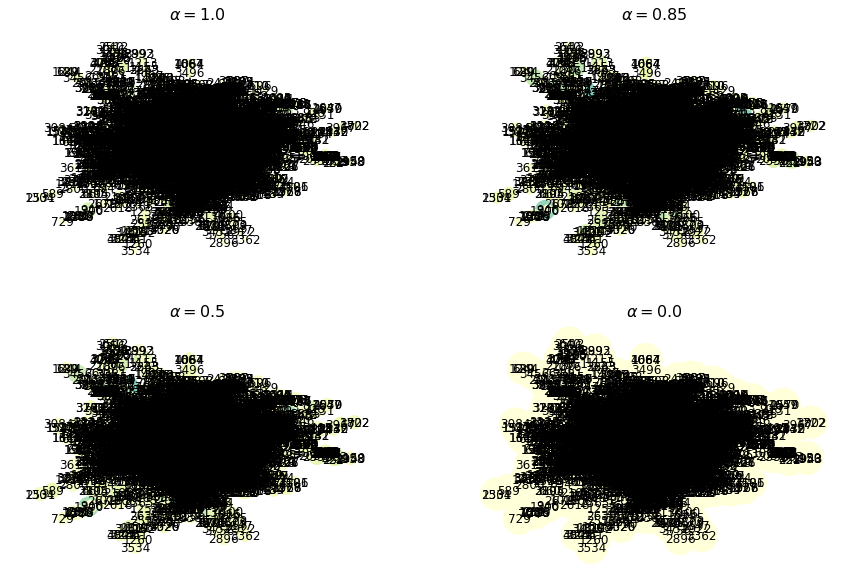

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15, 10))
plt.subplot(221)
draw_(G,pos, list(nx.pagerank(G, alpha=1.0).values()),r'$\alpha=1.0$')

plt.subplot(222)
draw_(G,pos, list(nx.pagerank(G, alpha=0.85).values()),r'$\alpha=0.85$')

plt.subplot(223)
draw_(G,pos, list(nx.pagerank(G, alpha=0.5).values()),r'$\alpha=0.5$')

plt.subplot(224)
draw_(G,pos, list(nx.pagerank(G, alpha=0.00).values()),r'$\alpha=0.0$')

**k -core - это максимальный связный подграф графа G, в котором все вершины имеют степень по меньшей мере  k .**

In [ ]:
def decomp(graph):
    core_len = num_nodes = graph.number_of_nodes()
    k=1
    core = dict()
    while core_len:
        nodes_in_core = set(nx.k_core(G, k=k).nodes()) # множество вершин k-core, nx.k_core — подграф
        core[k] = nodes_in_core
        core_len = len(nodes_in_core)
        k += 1
    return core # словарь — степень : вершина

In [ ]:
core_dict = decomp(G)
core_dict

{1: {1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,

In [ ]:
#каждой вершине максимальный k-core
cores = []
nodes = []
for core in list(core_dict.keys())[:-1]:
    cores.extend([core]*len(core_dict[core] - core_dict[core+1]))
    nodes.extend(list(core_dict[core] - core_dict[core+1]))

In [ ]:
df1 = pd.DataFrame({'core':cores, 'node':nodes})
df1['node'] = df1['node'].apply(int)
df1

,core,node
0,1,4096
1,1,4097
2,1,4098
3,1,5
4,1,2054
...,...,...
4153,43,4080
4154,43,1267
4155,43,118
4156,43,1784


In [ ]:
df2 = pd.merge(df, core_df, on="node").drop('node', axis=1)
df2 = df2[list(df2.columns[1:]) + ['target']]
df2

,degree,eigenvector,closeness,betweenness,core,target
0,0.000962,1.978526e-07,0.184101,0.002893,3,1.0
1,0.001443,1.930278e-08,0.159047,0.002290,3,1.0
2,0.000722,1.893130e-08,0.158980,0.000000,3,1.0
3,0.001203,5.769050e-07,0.171225,0.001707,3,0.0
4,0.000722,1.450752e-08,0.146260,0.000481,2,1.0
...,...,...,...,...,...,...
4153,0.000241,2.516598e-08,0.147349,0.000000,1,1.0
4154,0.000481,6.328154e-07,0.180261,0.000000,2,1.0
4155,0.000241,9.752772e-07,0.168655,0.000000,1,1.0
4156,0.000241,2.715108e-08,0.150550,0.000000,1,0.0


In [ ]:
df2.to_csv('graph_df.csv', index=False, header=True)

### **2. Исследуйте корреляцию между признаками и целевой переменой**

In [ ]:
df2.corr().style.background_gradient(cmap='Blues')

,degree,eigenvector,closeness,betweenness,core,target
degree,1.000000,0.600507,0.435221,0.488306,0.899057,0.005380
eigenvector,0.600507,1.000000,0.275792,0.135088,0.619236,0.014566
closeness,0.435221,0.275792,1.000000,0.473812,0.253214,0.012748
betweenness,0.488306,0.135088,0.473812,1.000000,0.134877,0.011753
core,0.899057,0.619236,0.253214,0.134877,1.000000,-0.001350
target,0.005380,0.014566,0.012748,0.011753,-0.001350,1.000000


In [ ]:
def h_score(model, params, X_train, y_train, evals=30):
  clf = model(**params)
  clf.fit(X_train, y_train)
  return -cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro').mean()

In [ ]:
space_lgbm = {
            'n_estimators': hp.choice('n_estimators', np.arange(50, 150, 30)),
            'learning_rate': hp.quniform('eta', 0.05, 0.3, 0.05),
            'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.1),
            } # параметры

In [ ]:
def h_model(model, params, X_train, y_train, evals=30):
  best = fmin(fn=h_score(model, params, X_train, y_train, evals), space=params, algo=tpe.suggest, max_evals=evals)
  return model(**space_eval(params, best))

In [ ]:
cat_features = []
for column in df2.columns:
  if df2[column].dtypes == 'object' and column != 'target' or column == 'core':
    cat_features.append(column)

ohe = OneHotEncoder()
cat_matrix = ohe.fit_transform(df2[cat_features]).toarray()

cols = []
  
for category in ohe.categories_:
  cols.extend(list(category))

cat_df = pd.DataFrame(cat_matrix, columns=cols)
cat_df.index = df2.index

cat_df


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,19,20,21,23,25,31,33,34,42,43
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4153,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4154,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4155,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4156,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df2

,degree,eigenvector,closeness,betweenness,core,target
0,0.000962,1.978526e-07,0.184101,0.002893,3,1.0
1,0.001443,1.930278e-08,0.159047,0.002290,3,1.0
2,0.000722,1.893130e-08,0.158980,0.000000,3,1.0
3,0.001203,5.769050e-07,0.171225,0.001707,3,0.0
4,0.000722,1.450752e-08,0.146260,0.000481,2,1.0
...,...,...,...,...,...,...
4153,0.000241,2.516598e-08,0.147349,0.000000,1,1.0
4154,0.000481,6.328154e-07,0.180261,0.000000,2,1.0
4155,0.000241,9.752772e-07,0.168655,0.000000,1,1.0
4156,0.000241,2.715108e-08,0.150550,0.000000,1,0.0


In [ ]:
train_df = df2.join(cat_df).drop(cat_features, axis=1)

X = train_df.drop(['target'], axis=1)
y = train_df.target

train_df

,degree,eigenvector,closeness,betweenness,target,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,19,20,21,23,25,31,33,34,42,43
0,0.000962,1.978526e-07,0.184101,0.002893,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.001443,1.930278e-08,0.159047,0.002290,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000722,1.893130e-08,0.158980,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.001203,5.769050e-07,0.171225,0.001707,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000722,1.450752e-08,0.146260,0.000481,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4153,0.000241,2.516598e-08,0.147349,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4154,0.000481,6.328154e-07,0.180261,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4155,0.000241,9.752772e-07,0.168655,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4156,0.000241,2.715108e-08,0.150550,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
def get_score(params, X_train, y_train, df, model, target='target', optimization=False):
  estimator = model
  estimator.fit(X_train, y_train)
  y_predicted = estimator.predict(X_test)
  print(classification_report(y_predicted, y_test))
  print('roc_auc_score:', roc_auc_score(y_predicted, y_test))
  return estimator

In [ ]:
h_model_res = get_score(space_lgbm, X_train, y_train, df2, LGBMClassifier(), optimization=False)

              precision    recall  f1-score   support

         0.0       0.21      0.38      0.27       250
         1.0       0.74      0.55      0.63       790

    accuracy                           0.51      1040
   macro avg       0.47      0.46      0.45      1040
weighted avg       0.61      0.51      0.54      1040

roc_auc_score: 0.4647848101265823


**4. Проанализируйте важность признаков**

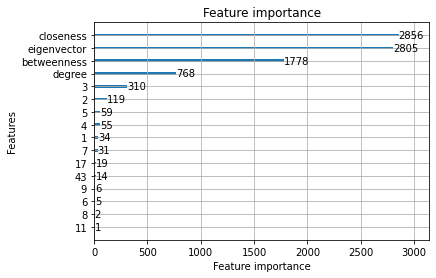

In [ ]:
lightgbm.plot_importance(h_model_res)

## 2. Предсказание связей (10 баллов)

1. Разбейте сеть на обучающую и тестовую выборку, тестовая выборка должна содержать как связи, которые нужно предсказать, так и отсутствующие (выберите их случайным образом, чтобы тестовая выборка была сбалансирована). 

2. Сравните Roc-кривые для различных структурных характеристик ребер в сети. Какая лучше справляется с задачей предсказания связей по AUC ROC? 

3. Постройте модель классификации, используя структурные признаки, улучшилось ли качество предсказания?

4. Постройте модель предскзания на основе вложения (используйте вложение сети с помощью Лапласиана или Node2vec, на выбор) Сравните качество предсказания для разных размерностей используемого пространства $d$. 



**1. Разбейте сеть на обучающую и тестовую выборку, тестовая выборка должна содержать как связи, которые нужно предсказать, так и отсутствующие (выберите их случайным образом, чтобы тестовая выборка была сбалансирована).**

In [ ]:
import random

In [ ]:
!gdown --id 1RbDHK1Rf3sUj10zKxcaVN385LTo6QQuO

Downloading...
From: https://drive.google.com/uc?id=1RbDHK1Rf3sUj10zKxcaVN385LTo6QQuO
To: /content/email-Eu-core.txt
100% 193k/193k [00:00<00:00, 28.9MB/s]


In [ ]:
G = nx.read_edgelist('email-Eu-core.txt')

Выделим $25 \%$ ребер на тестовую выборку:

In [ ]:
test_edges_subset = random.sample(G.edges(), int(0.25 * G.number_of_edges()))

G_train = G.copy()
G_train.remove_edges_from(test_edges_subset)

In [ ]:
train_edges_subset = list(G_train.edges())

In [ ]:
from itertools import combinations

In [ ]:
# возможные связи - те, которые есть
not_existing_edges = set(combinations(range(G.number_of_nodes()), 2)) -  set(map(lambda x: (int(x[0]), int(x[1])), set(G.edges()))) -  set(map(lambda x: (int(x[1]), int(x[0])), set(G.edges())))

In [ ]:
# нужно, чтобы train и test были сбалансированы
not_existing_test = list(map(lambda x: (str(x[0]), str(x[1])), random.sample(not_existing_edges, len(test_edges_subset))))
not_existing_train = list(map(lambda x: (str(x[0]), str(x[1])), random.sample(not_existing_edges - set(not_existing_test), len(train_edges_subset))))

In [ ]:
len(not_existing_test) == len(test_edges_subset)

True

In [ ]:
len(not_existing_train) == len(train_edges_subset)

True

In [ ]:
test_edges = test_edges_subset + not_existing_test
train_edges = train_edges_subset + not_existing_train

In [ ]:
y_test = [1]*len(test_edges_subset) + [0]*len(test_edges_subset)
y_train = [1]*len(train_edges_subset) + [0]*len(train_edges_subset)

**2. Сравните Roc-кривые для различных структурных характеристик ребер в сети. Какая лучше справляется с задачей предсказания связей по AUC ROC?**

In [ ]:
jaccard_test = list(nx.jaccard_coefficient(G_train, test_edges))
jaccard_train = list(nx.jaccard_coefficient(G_train, train_edges))

In [ ]:
jaccard_test_scores = np.array(jaccard_test)[:, 2].astype(float)
jaccard_train_scores = np.array(jaccard_train)[:, 2].astype(float)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, jaccard_test_scores)

In [ ]:
roc_auc_score(y_test, jaccard_test_scores)

0.9225200493423467

Text(0, 0.5, 'True Positive Rate')

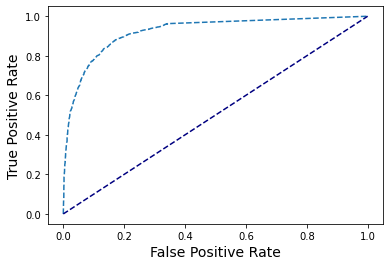

In [ ]:
plt.plot(fpr,tpr,'--')
plt.plot([0, 1], [0, 1], color="navy",  linestyle="--")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)

In [ ]:
alloc_test = list(nx.resource_allocation_index(G_train, test_edges))
alloc_train = list(nx.resource_allocation_index(G_train, train_edges))
alloc_test_scores = np.array(alloc_test)[:, 2].astype(float)
alloc_train_scores = np.array(alloc_train)[:, 2].astype(float)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, alloc_test_scores)

In [ ]:
roc_auc_score(y_test, alloc_test_scores)

0.9399895097051569

Text(0, 0.5, 'True Positive Rate')

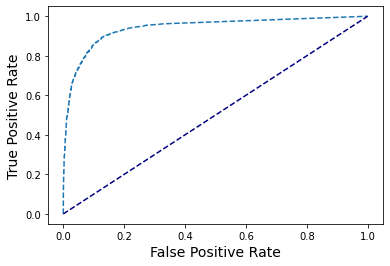

In [ ]:
plt.plot(fpr,tpr,'--')
plt.plot([0, 1], [0, 1], color="navy",  linestyle="--")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)

**3. Постройте модель классификации, используя структурные признаки, улучшилось ли качество предсказания?**

In [ ]:
df_train = pd.DataFrame({'jaccard':jaccard_train_scores, 'alloc':alloc_train_scores})
df_test = pd.DataFrame({'jaccard':jaccard_test_scores, 'alloc':alloc_test_scores})

In [ ]:
lgbm = LGBMClassifier()
lgbm.fit(df_train, y_train)
probas = lgbm.predict_proba(df_test)
preds = lgbm.predict(df_test)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])

In [ ]:
roc_auc_score(y_test, probas[:, 1])

0.9398837982230149

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4176
           1       0.88      0.88      0.88      4176

    accuracy                           0.88      8352
   macro avg       0.88      0.88      0.88      8352
weighted avg       0.88      0.88      0.88      8352



Text(0, 0.5, 'True Positive Rate')

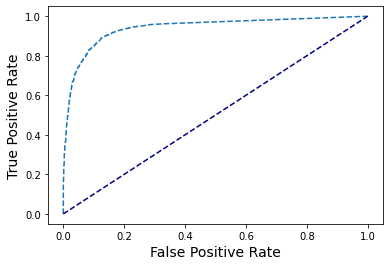

In [ ]:
plt.plot(fpr,tpr,'--')
plt.plot([0, 1], [0, 1], color="navy",  linestyle="--")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)

## 3. Задача кластеризации (10 баллов)

 Каждый сотдрудник относится к одному из департаментов, которые и являются истинными сообществами в сети. 

1. Постройте распределение размеров сообществ в сети, какова доля вершин в наибольшем сообществе? В наименьшем? 

2. Рассмотрим задачу поиска сообществ с помощью агломеративного метода, постройте зависимость метрик качества от числа задаваемых сообществ. 
Какое разбиение оказывается более близким к истинному? 

3. Выполните пункт 2) для алгоритма Гирвана-Ньюмана. Сравните качество агломеративного метода и Гирвана-Ньюмана. 

In [ ]:
!gdown --id 1HAbbeu1c1zweg-2zp352JDakJ7tZAlEv

Downloading...
From: https://drive.google.com/uc?id=1HAbbeu1c1zweg-2zp352JDakJ7tZAlEv
To: /content/email-Eu-core-department-labels.txt
100% 6.54k/6.54k [00:00<00:00, 11.8MB/s]


In [ ]:
email = nx.read_edgelist('email-Eu-core.txt')
labels = pd.read_csv('email-Eu-core-department-labels.txt', sep=' ', names=['node', 'label'])

**1. Постройте распределение размеров сообществ в сети, какова доля вершин в наибольшем сообществе? В наименьшем?**

доля вершин в наибольшем сообществе: 0.108
доля вершин в наименьшем сообществе: 0.001


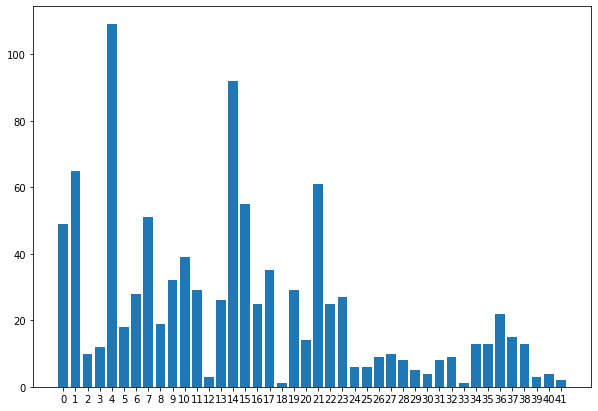

In [ ]:
plt.figure(figsize=(10, 7))
plt.bar(labels['label'].value_counts().index.values, labels['label'].value_counts())
plt.xticks(labels['label'].value_counts().index.values)
print(f"доля вершин в наибольшем сообществе: {max(labels['label'].value_counts()) / len(labels):.3f}")
print(f"доля вершин в наименьшем сообществе: {min(labels['label'].value_counts()) / len(labels):.3f}")

**2. Рассмотрим задачу поиска сообществ с помощью агломеративного метода, постройте зависимость метрик качества от числа задаваемых сообществ. 
Какое разбиение оказывается более близким к истинному?**

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import normalized_mutual_info_score

In [ ]:
def similarity_matrix(G, nodelist=None):
    if (nodelist is None):
        nodelist=list(G.nodes)

    Smatrix=np.zeros((len(nodelist), len(nodelist)))

    for i, node1 in enumerate(nodelist):
        for j, node2 in enumerate(nodelist[i+1:], start = i+1):
            Smatrix[i,j]=(len(set(G[node1]) & set(G[node2])) + int(G.has_edge(node1,node2)))/(np.min([len(G[node1]),len(G[node2])])
                                                                                          +1-int(G.has_edge(node1,node2)))
            Smatrix[j,i]=Smatrix[i,j]

    return Smatrix

In [ ]:
def ag_score(clusters):
    res = []
    for n_clusters in clusters:
        communities = AgglomerativeClustering(linkage='average', n_clusters = n_clusters)
        X=similarity_matrix(email,nodelist=None)
        communities.fit(X)
        res.append(normalized_mutual_info_score(labels['label'].values.astype('int'), communities.labels_))
    return res
    

In [ ]:
clusters = list(range(5, 50, 5))
res = ag_score(clusters)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:542: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:542: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:542: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:542: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix l

Text(0, 0.5, 'Взаимная информация')

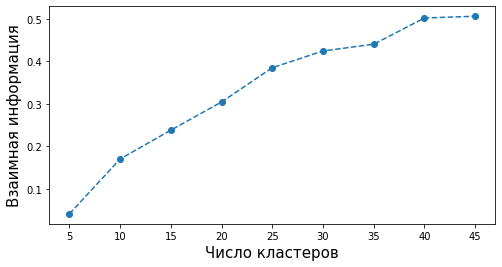

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(clusters, res, 'o--')
plt.xticks(clusters)
plt.xlabel('Число кластеров', fontsize=15)
plt.ylabel('Взаимная информация', fontsize=15)

**3. Выполните пункт 2) для алгоритма Гирвана-Ньюмана. Сравните качество агломеративного метода и Гирвана-Ньюмана.**

In [ ]:
from networkx.algorithms import community as com
import itertools

In [ ]:
comps=com.girvan_newman(email)

In [ ]:
num_clusters = []
scores = []
for communities in itertools.islice(comps, 0, 30, 2):
    l=list(sorted(c) for c in communities)
    num_clusters.append(len(l))
    preds =  np.zeros(len(labels))
    for i, community in enumerate(l):
        for node in community:
            preds[int(node)] = i
    scores.append(normalized_mutual_info_score(labels['label'].values.astype('int'), preds))

Text(0, 0.5, 'Взаимная информация')

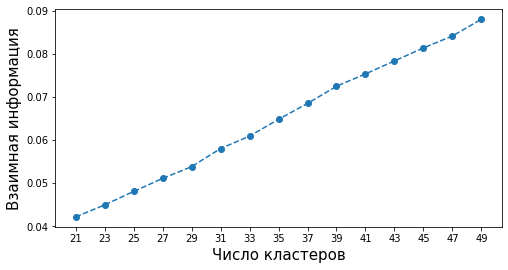

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(num_clusters, scores, 'o--')
plt.xticks(num_clusters)
plt.xlabel('Число кластеров', fontsize=15)
plt.ylabel('Взаимная информация', fontsize=15)

### Агломеративные методы поиска сообществ 
Напишем функцию, вычисляющую матрицу схожести $X$ вершин простого графа, элементы матрицы:
$$
x_{ij}=\frac{J(i,j)+A_{ij}}{min(k_i,k_j)+1-A_{ij}},
$$
$J(i,j)$-число общих соседей вершин $i$ и $j$, A - матрица смежности: